# Globally centred discrete snakes

In this notebook, we simulate two specific examples of globally centred discrete snakes. We will require the following libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [2]:
random.seed(0)

## Background and discrete snake definition
A __branching walk__ is a pair $(T,l)$ where $T$ is a rooted ordered tree, and $l:T\rightarrow \mathbb{R}$ is a label function.  For the purposes of this specific notebook, we endow the set of underlying trees with the distribution of a Biemaymé branching process with Poisson(1) offspring distribution. 

We assume that the label of the root is zero, i.e., $l(\emptyset) = 0$. To define the labels of the remaining vertices we let $(\nu_k)_{k\ge 1}$ be a family of distributions such that for all $k\ge 1$, $\nu_k$ is a distribution on $\mathbb{R}^k$. For each $k\ge 1$, $\nu_k$ is the distribution of the displacements of the children of a vertex with $k$ children. We write $Y^k = (Y_{k,1},...,Y_{k,k})$ for a random variable with distribution $\nu_k$.


We assume that conditionally on the underlying tree, $T$, for any $u\in T$ the displacements of each of its children are independent. 

We further assume that the branching walk is _globally centred_
\begin{equation}\sum_{k = 1}^\infty \mu_k \sum_{j=1}^k \mathbf{E}[Y_{k,j}] = 0,\end{equation}
and admits _finite global variance_
\begin{equation}\sum_{k=1}^\infty \mu_k \sum_{j=1}^k \mathbf{E}[Y^2_{k,j}] = \beta^2 < \infty.\end{equation}

### Encodings
A branching walk is encoded with the help of two processes; one to encode the genealogy of the underlying tree, and one to capture the additional spatial motion described by the labels. These processes can be descibed as follows.

Suppose that $T$ has $n+1$ vertices. 

Define a function $\tilde f_T:\{0,..., 2n\} \rightarrow T$, seen as the depth-first exploration of $T$, as follows. Let $\tilde f_T(0) = \emptyset$. Given that $\tilde f_T(i) = u_1...u_k$, choose if possible the next child of $u$ in the lexicographical order of $T$ which has yet to be explored, $w$, and set $\tilde f_T(i+1) = w$. If no such element exists, set $\tilde f_T(i+1) = p(u)$. 
For $0 \le i \le 2n$ let  

\begin{equation} C_T(i) = d(\emptyset, \tilde f_T(i)),\end{equation}

and 

\begin{equation}R_T(i) = l(\tilde f_T(i)).\end{equation}

The __contour process__ $(C_T(2ns), s\in [0,1])$ and spatial contour process $(R_T(2ns), s\in[0,1])$ are obtained by linearly interpolating the sequences $(C_T(i), 0 \le i \le n)$ and $(R_T(i), 0 \le i \le n)$ respectively. The process $(C_T, R_T)$ is called the __head of the discrete snake__.

The __discrete snake__ is the path valued process $(C_T, \Phi)$ where $\Phi$ is the set of random walk trajectories associated with each vertex of $T$.

### Nodes

In [3]:
class Node:
    def __init__(self,data):
        self.data = data                                       # Will hold the i.i.d displacement of the vertex
        self.label = None                                      # Corresponds to the Ulam-Harris label of each node. 
        self.parent = None
        self.children = []
        self.height = None

### The Aldous-Broder algorithm

We use the Aldous-Broder algorithm to construct a size-conditioned Poisson(1) Biemayé tree:


- Fix $n \ge 2$.
- Take the root vertex to be $1$.
- For $2 \le i \le n$, connect vertex $i$ to vertex $V_i = \min(U_i, i-1)$, where $U_1,...,U_n$ are independent and uniform over $1,...,n$.
- Remove the labels.

In so doing, we will update the height and label fields of each node.

In [4]:
def aldous_broder(n):
    
    nodes = [Node(i) for i in range(n)]
    
    # Assign label 0 to the root, i.e., Node(1).
    nodes[0].label = "0"
    
    # Set the height of the root to be 0.
    nodes[0].height = 0
    
    # Sample n independent uniform random variables from 1,...,n.
    uniform = np.random.randint(0, n, size = n)
    
    # Attach each node according to the Aldous-Broder algorithm.
    for i in range(1, n):
        v_i = min(uniform[i-1], i-1)
        
        nodes[i].parent = nodes[v_i]
        ((nodes[i].parent).children).append(nodes[i])
        
        # Set the height of each node to be that of its parent + 1.
        nodes[i].height = (nodes[i].parent).height + 1
    
    # Assign random permutation and label with Ulam-Harris notation
    for node in nodes:
        if len(node.children) != 0:
            random.shuffle(node.children)
            
            for i in range(1,len(node.children)+1):
                node.children[i-1].label = node.label + str(i)
    
    # Return the set of nodes, i.e., the tree.
    return nodes

## $R_T$ for label function #1

The first label function we will choose is given by $Y_{k,j} = 1 - 2(k-j)$. Namely, the difference between the height and depth-first queue value of each node. 

The trajectory of a single node is obtained through the function __label_1(node)__. The trajectories of all nodes are then stored in a dictionary using the function __trajectories(tree)__. 

In [5]:
def label_1(node):
    
    # If the node is the root, its trajectory is [0]
    traject = [0]
    
    # Otherwise, recurse and add the new step
    if node.height != 0:
        par_traject = label_1(node.parent)
        last_pos = par_traject[-1]
        k = len((node.parent).children)
        j = int(node.label[-1])
        traject = par_traject + [last_pos + 1 - 2*(k-j)]
        
    return traject

## $R_T$ for i.i.d. centred labels
We now take $Y_{k,j}$ to be i.i.d centred. More specifically, we take the $Y_{k,j}$ to be $\pm 1$ fair coin flips. 

In [6]:
def label_2(node):
    
    # If the node is the root, its trajectory is [0]
    traject = [0]
        
    # Otherwise, recurse and add the new step
    if node.height != 0:
        par_traject = label_2(node.parent)
        last_pos = par_traject[-1]
        traject = par_traject + [last_pos + node.data]
    
    return traject

## The snake
We must perform a depth-first search of the tree (using the Ulam-Harris ordering), to obtain the path valued process $(C_T, \Phi)$. This is done using the function __snake(tree, trajects)__. Note that the length of a node's trajectory is precisely its height.

All trajectories for the tree are stored in a dictionary using the function __trajectories(tree, opt)__. The parameter opt tells us which label process to choose.

In [7]:
def trajectories(tree, opt):
    
    trajectories = {}
    if opt == 1:
        for node in tree:
            trajectories[node] = label_1(node)
    
    if opt == 2:
        for node in tree:
            node.data = np.random.binomial(1,1/2) - 1/2
        
        for node in tree:
            trajectories[node] = label_2(node)
            
    return trajectories

In [8]:
def snake(tree, trajects):
    
    # Start the depth-first search from the root.
    snake = [trajects[tree[0]]]
    explored = []
    seen = [tree[0]]
    node = tree[0]
    
                    
    while len(explored) != len(tree):
       
        children = node.children
        un_seen = []
        
        if len(children) == 0:
            explored.append(node)
            node = node.parent
            snake.append(trajects[node])
            
        if len(children) != 0:
            for child in children:
                if child not in seen:
                    un_seen.append(child)
          
            if len(un_seen) != 0:
                child = un_seen[0]
                snake.append(trajects[child])
                seen.append(child)
                node = child
                
            if len(un_seen) == 0 and node.parent != None:
                explored.append(node)
                node = node.parent
                snake.append(trajects[node])
          
            if len(un_seen) == 0 and node.parent == None:
                explored.append(node)
                
    return snake

## Obtain the snake for a tree of fixed size n = 25,000

In [9]:
n = 25000
tree = aldous_broder(n)

In [10]:
trajects_1 = trajectories(tree,1)
snake_1 = snake(tree, trajects_1)

In [11]:
trajects_2 = trajectories(tree, 2)
snake_2 = snake(tree, trajects_2)

### Plot the snake of the tree 
We plot the snakes appropriately rescaled, i.e., by $\sqrt{n}$ in $x$, and by $n^{1/4}$ in $y$. This is because distances in the tree are on the order of $\sqrt{n}$, and as such by the central limit theorem we should expect that the random walk trajectories should be on the order of $n^{1/4} = \sqrt{\sqrt{n}}$. In the plot, we include the shadow of the snake (in gray), which corresponds to the area under the contour process.

More specifically, writting $T_n$ for a Poisson(1)-Bienaymé tree with $n+1$ vertices it has been shown that for both of these label function (1 and 2)
\begin{equation}
\left(\frac{C_{T_n}(\lfloor 2nt\rfloor)}{\sqrt{n}}, \frac{R_{T_n}(\lfloor 2nt \rfloor)}{n^{1/4}}\right)_{0 \le t \le 1} \stackrel{d}{\rightarrow} \left(\frac{2}{\sigma}\mathbf{e}_t, \beta \mathbf{r}_t\right)_{0 \le t \le 1},
\end{equation}
in $\mathbf{D}([0,1], \mathbb{R}^2)$, where $\sigma$ is the standard deviation of $\mu$, $\mathbf{e}$ is a normalized Brownian excursion, and conditionally on $\mathbf{e}$, $\mathbf{r}$ is a centred Gaussian process with covariance 
\begin{equation}
\mathrm{cov}(\mathbf{r}_s, \mathbf{r}_t) = \frac{2}{\sigma}\min_{s\wedge t \le u \le s\vee t} \mathbf{e}_u.
\end{equation}

A similar convergence theorem also holds for the discrete snake itself.

It should be noted that the result holds in more generality. 

In [12]:
def plot_snake(snake):
    ax = plt.figure(figsize = (10, 10)).add_subplot(projection='3d')
    plt.grid(None)
    plt.axis('off')

    for i in range(len(snake)):
        x = [j/math.sqrt(n) for j in range(len(snake[i]))]
        y = (-1)*8*np.ones(len(snake[i]))
        ax.plot(x,y,zs = i/(2*(n-1)), zdir = 'y', label = 'curve in (x,y)', color = 'lightgray', linewidth=1, alpha = 0.1)

    for i in range(len(snake)):
        x = [j/math.sqrt(n) for j in range(len(snake[i]))]
        y = [label/(n**0.25) for label in snake[i]]
        ax.plot(x, y, zs=i/(2*(n-1)), zdir='y', label='curve in (x, y)',color = 'black', linewidth = 0.03, alpha = 0.3)
    
    plt.show()

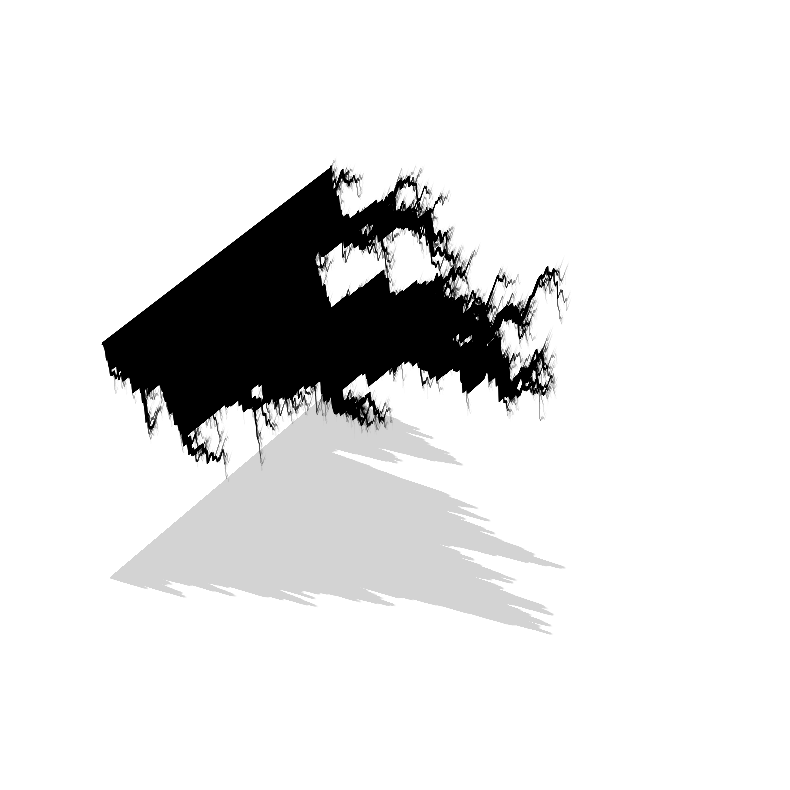

In [13]:
# Plot the snake with displacements Y_{k,j} = 1 + 2(k-j)
plot_snake(snake_1)

In [ ]:
# Plot the snake with fair coin flip displacements
plot_snake(snake_2)

### Plot the head of the discrete snake 
We plot the head of the discrete snake (rescaled by $n^{1/4}$) and save it in the file __deterministic_head__.

Plotting for the head of the second discrete snake is done similarly.

In [ ]:
def plot_head(snake):
    x = [i/(2*(n-1)) for i in range(len(snake))]
    y = [traject[-1]/(n**0.25) for traject in snake]
    

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, linewidth = 0.5, color = 'black')
    ax.set_yticks([0, -4, 4])
    ax.set_xticks([0,0.5, 1])
    
    plt.show()

In [ ]:
# Plot the head of the snake with displacements Y_{k,j} = 1 + 2(k-j)
plot_head(snake_1)

In [ ]:
# Plot the head of the snake with fair coin flip displacements
plot_head(snake_2)